In [2]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr_web

from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARIMA

from arch import arch_model

C:\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


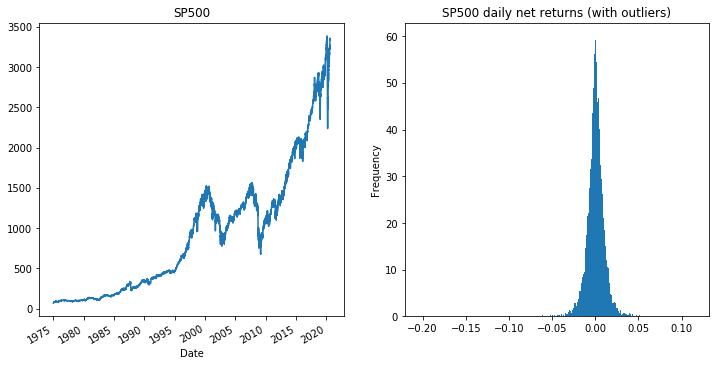

In [3]:
start_date = datetime.date(1975, 1, 1)
end_date = datetime.date.today()

# some stock and indeces to inspect
# S&P500, Tesla
sp500 = pdr_web.DataReader('^GSPC', 'yahoo', start_date, end_date)
# tesla = pdr_web.DataReader('TSLA', 'yahoo', start_date, end_date)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6));

# Historical trend
sp500['Adj Close'].plot(ax=axes[0], title='SP500');
# tesla['Adj Close'].plot(ax=axes[1], title='Tesla');

# daily net returns
sp500_returns = (sp500['Adj Close'].shift(-1) / sp500['Adj Close']).dropna() - 1
sp500_returns.plot.hist(ax=axes[1], density=True, bins=300, title='SP500 daily net returns (with outliers)');


p-values from Ljung-Box test for SP500 price:
null hypothesis is that all the examined lagged autocorrelation indicates lack of correlation
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

p-values from Ljung-Box test for SP500 net returns:
[1.95146767e-06 2.05727393e-06 7.41191284e-06 2.32921512e-07
 7.11967627e-07 1.54475194e-07 2.38305058e-07 2.72503869e-08
 5.42948374e-09 1.35029212e-08]

p-values from Ljung-Box test for SP500 ABSOLUTE net returns:
[1.18369978e-175 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+00

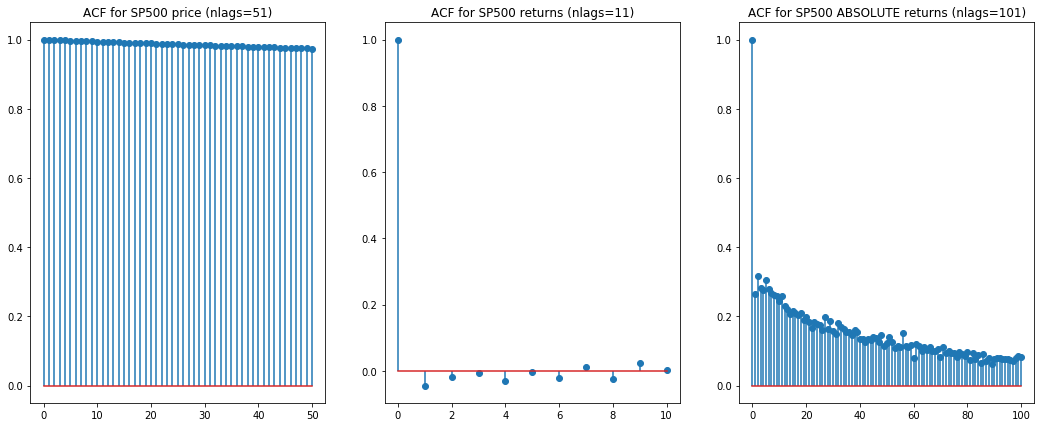

In [4]:
# 
# TIME SERIES ANALYSIS of SP500 index
# ACF: no parametric models
#

# PRICES FOLLOWS A TREND -> ARE obviously CORRELATED
#
# at first, analyze autocorrelation function (ACF) without any parametric model
# the price series is clearly not stationary, and there should be strong autocorrelation
sp500_values = sp500['Adj Close'].values
sp500_acf, sp500_qstat, sp500_acf_pval = stattools.acf(sp500_values, nlags=50, fft=True, qstat=True, alpha=None)
print('p-values from Ljung-Box test for SP500 price:\n'
      'null hypothesis is that all the examined lagged autocorrelation' 
      ' indicates lack of correlation')
print(sp500_acf_pval, end="\n\n")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 7));
axes[0].stem(sp500_acf, use_line_collection=True);
axes[0].set_title('ACF for SP500 price (nlags={})'.format(sp500_acf.size));

# RETURNS LACK CORRELATIONS
#
# Return series, on the other hand, should be closer to be stationary and lacking of auto-correlation
# NB: still, p-values are not high enough to justify the assumption of complete independence
# Note also the negative correlation at 1 day lag. This can be due to the following: especially in periods of high volatility,
# it is unlikely that e.g. a sudden drop (i.e. negative return) one day is followed also by a loss the day after; 
# plus, there are also arbitrageur exploiting momentum strategies, which brings returns "back to equilibrium"
sp500_ret_acf, sp500_ret_qstat, sp500_ret_acf_pval = stattools.acf(sp500_returns.values, nlags=10, fft=True, qstat=True, alpha=None)
print('p-values from Ljung-Box test for SP500 net returns:')
print(sp500_ret_acf_pval, end="\n\n")

axes[1].stem(sp500_ret_acf, use_line_collection=True);
axes[1].set_title('ACF for SP500 returns (nlags={})'.format(sp500_ret_acf.size));

# VOLATILITY CLUSTERING
#
# Check indipendence on absolute values of returns
# The absolute changes in returns are correlated because of volatility clustering. In periods of high volatility
# high oscillations (both positive or negative) are observed; similarly, in more static regimes, returns are more "flat"
# Note that, as time goes on, this type of correlation tend to disappear as expected: the decay time can provide
# an estimate of the time period characterized by a certain volatility regime.
sp500_absret_acf, sp500_absret_qstat, sp500_absret_acf_pval = stattools.acf(np.abs(sp500_returns.values), nlags=100, fft=True, qstat=True, alpha=None)
print('p-values from Ljung-Box test for SP500 ABSOLUTE net returns:')
print(sp500_absret_acf_pval, end="\n\n")

axes[2].stem(sp500_absret_acf, use_line_collection=True);
axes[2].set_title('ACF for SP500 ABSOLUTE returns (nlags={})'.format(sp500_absret_acf.size));


p-value from Augmented Dick-Fuller (ADF) test for SP500 time series: 0.998
As expected there are unit roots with really high confidence, hence the series is not stationary


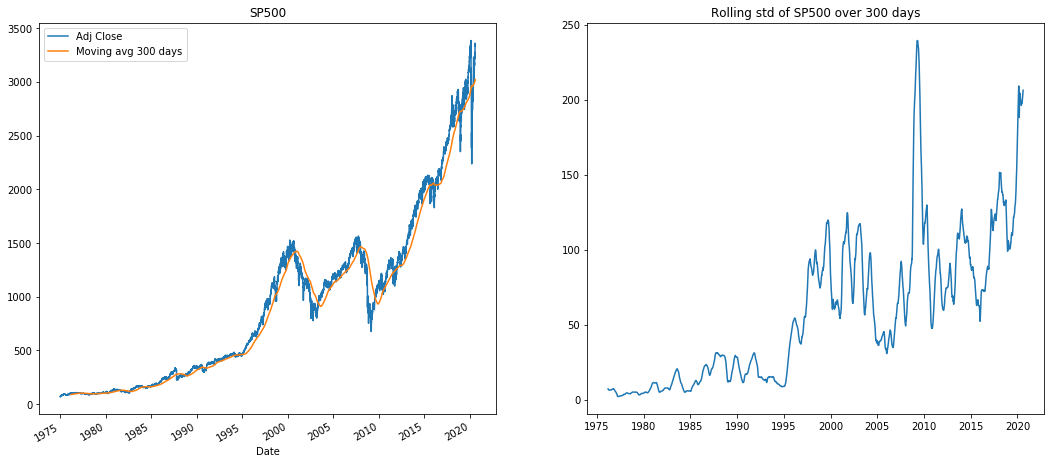

In [5]:
# 
# TIME SERIES ANALYSIS of SP500 index series
#
fig_series, ax_series = plt.subplots(nrows=1, ncols=2, figsize=(18,8));
sp500['Adj Close'].plot(ax=ax_series[0], title='SP500');

# Clearly the series is not stationary. Run Augmented Dick-Fuller test just for fun..
adf_results = stattools.adfuller(sp500['Adj Close'], regresults=True)
adf_pval = adf_results[1]
print('p-value from Augmented Dick-Fuller (ADF) test for SP500 time series:',"{:.3f}".format(adf_pval))
print('As expected there are unit roots with really high confidence, hence the series is not stationary')

# display rolling mean and rolling std to enlight the pretty obvious fact 
# that the price series ha no constant mean; what about variance?
sp500_rolling_mean = sp500['Adj Close'].rolling(window=300).mean()
sp500_rolling_std = sp500['Adj Close'].rolling(window=300).std()

ax_series[0].plot(sp500_rolling_mean, label='Moving avg 300 days'); ax_series[0].legend()
ax_series[1].plot(sp500_rolling_std);
ax_series[1].set_title('Rolling std of SP500 over 300 days');


p-value from Augmented Dick-Fuller (ADF) test for SP500 returns: 0.000
According to ADF test the return series has no unit roots
Notheless, the series seems to exhibit volatility clustering (???)

From the analysis of the ACF and PACF correlograms, it seems that no significant correlation (i.e. within 0.05) is present in the series of SP500 returns. Thus the series actually seems to be stationary white noise

Using ARIMA models to seek some sort of pattern in the return series for sp500 returns seems worthless


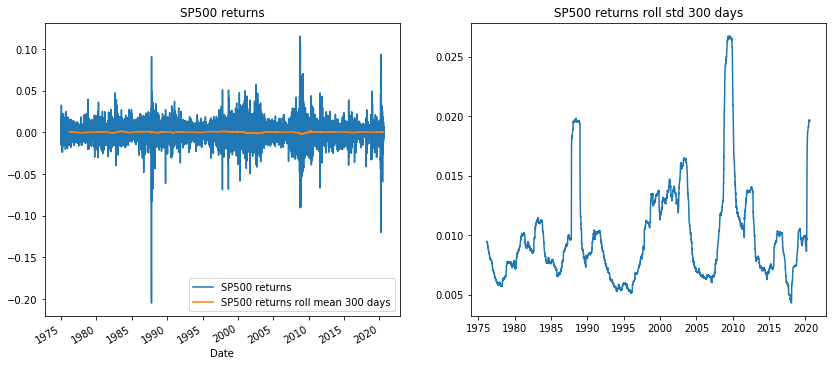

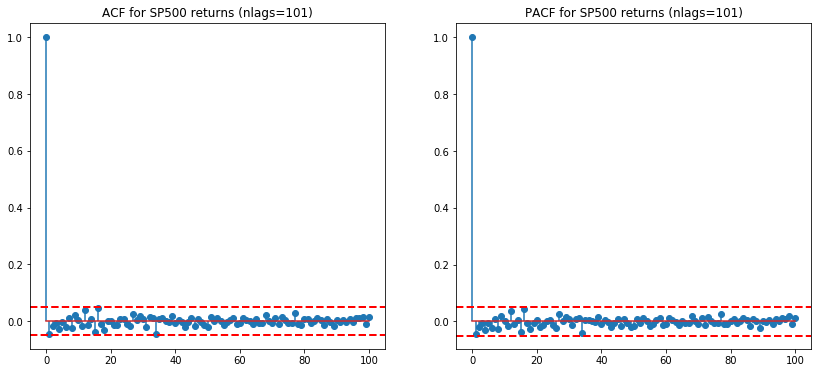

In [6]:
#
# TIME SERIES ANALYSIS of SP500 returns series (which should be closer to be stationary)
#
# let's heuristically examine the series by means of plots
fig_ret_ts, ax_ret_ts = plt.subplots(nrows=1, ncols=2, figsize=(14,6));
sp500_returns.plot(ax=ax_ret_ts[0], title='SP500 returns', label='SP500 returns');
sp500_returns_roll_mean = sp500_returns.rolling(window=300).mean()
sp500_returns_roll_std = sp500_returns.rolling(window=300).std()
ax_ret_ts[0].plot(sp500_returns_roll_mean, label='SP500 returns roll mean 300 days');
ax_ret_ts[0].legend()

ax_ret_ts[1].plot(sp500_returns_roll_std);
# From this plot we can notice Heteroskedascity: variance has a time dependence, tending to "cluster"
ax_ret_ts[1].set_title('SP500 returns roll std 300 days');

# Run againg ADF test: 
adf_ret_results = stattools.adfuller(sp500_returns.values, regresults=True)
adf_ret_pval = adf_ret_results[1]
print('p-value from Augmented Dick-Fuller (ADF) test for SP500 returns:',"{:.3f}".format(adf_ret_pval))
print('According to ADF test the return series has no unit roots')
print('Notheless, the series seems to exhibit volatility clustering (???)', end='\n\n')
# TODO: this result of ADF test contradicts the observed heteroskedasticy (???)

# Try to fit the return series to an ARIMA model
# Try first with an ARMA(p,q) model (no differencing), since the series doesn't seem to have a trend
# Display:
#  - ACF plot to have a clue on the number of q terms for the MA part,
#  - PCF plot to guess the number of p parameters for the AR part

fig_cf, ax_cf = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sp500_ret_acf, sp500_ret_qstat, _ = stattools.acf(sp500_returns.values, nlags=100, fft=True, qstat=True, alpha=None)
sp500_ret_pacf = stattools.pacf(sp500_returns.values, nlags=100, alpha=None)

ax_cf[0].stem(sp500_ret_acf, use_line_collection=True);
ax_cf[0].axhline(0.05, color ='r', linestyle='--', lw = 2)
ax_cf[0].axhline(-0.05, color ='r', linestyle='--', lw = 2)
ax_cf[0].set_title('ACF for SP500 returns (nlags={})'.format(sp500_ret_acf.size));

ax_cf[1].stem(sp500_ret_pacf, use_line_collection=True);
ax_cf[1].axhline(0.05, color ='r', linestyle='--', lw = 2)
ax_cf[1].axhline(-0.05, color ='r', linestyle='--', lw = 2)
ax_cf[1].set_title('PACF for SP500 returns (nlags={})'.format(sp500_ret_pacf.size));
print('From the analysis of the ACF and PACF correlograms, it seems '
      'that no significant correlation (i.e. within 0.05) is present '
      'in the series of SP500 returns. Thus the series actually seems to be stationary white noise', end='\n\n')

print('Using ARIMA models to seek some sort of pattern in the return series for sp500 returns seems worthless')


Iteration:      1,   Func. Count:      5,   Neg. LLF: 639.1951921686989
Iteration:      2,   Func. Count:     16,   Neg. LLF: 638.3220097049432
Iteration:      3,   Func. Count:     22,   Neg. LLF: 636.7067790155332
Iteration:      4,   Func. Count:     27,   Neg. LLF: 636.4970123144483
Iteration:      5,   Func. Count:     32,   Neg. LLF: 636.4959629082807
Iteration:      6,   Func. Count:     38,   Neg. LLF: 636.4956762582601
Iteration:      7,   Func. Count:     43,   Neg. LLF: 636.4956064882723
Iteration:      8,   Func. Count:     48,   Neg. LLF: 636.4956036960477
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 636.4956037594906
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8

**************

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   A

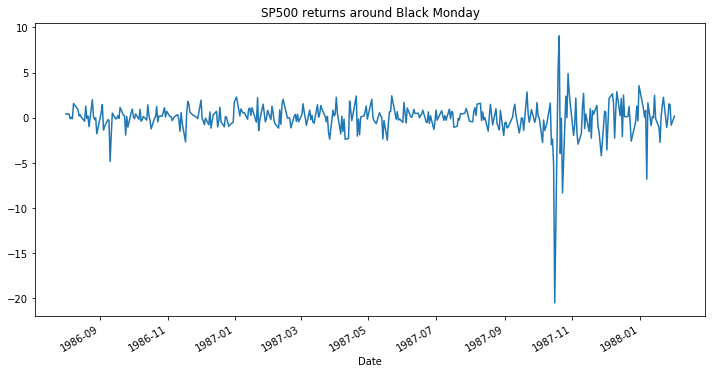

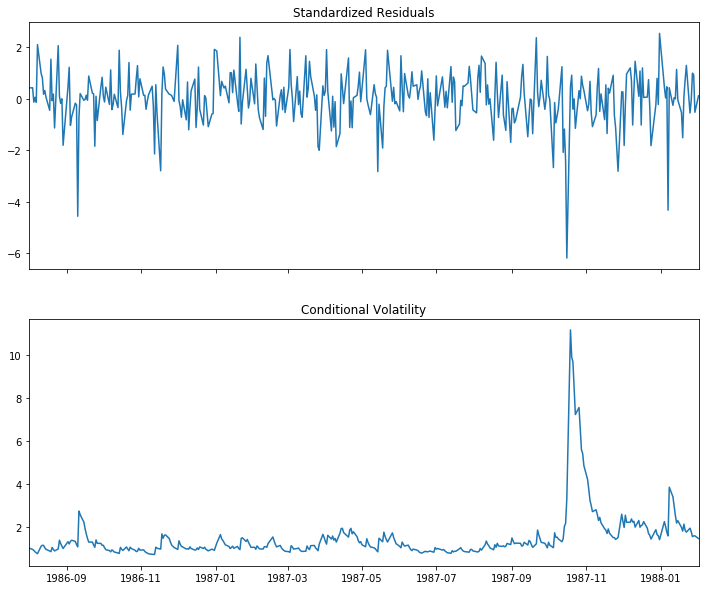

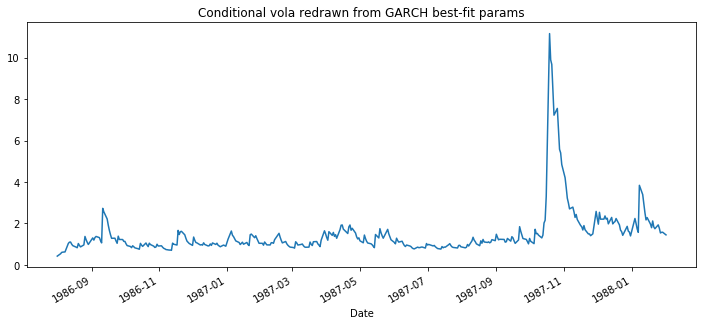

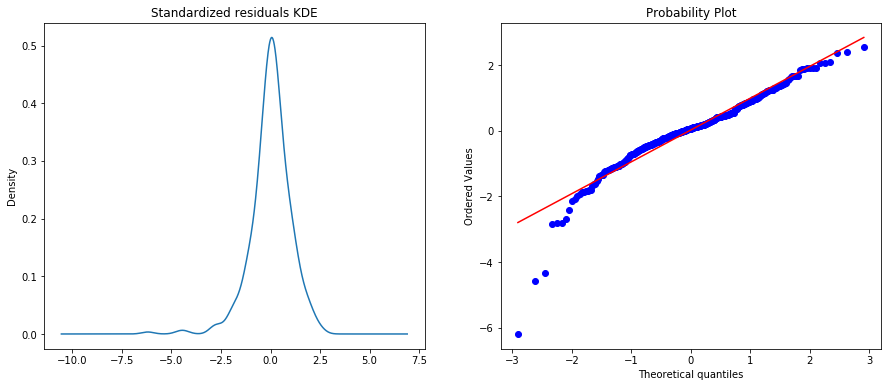

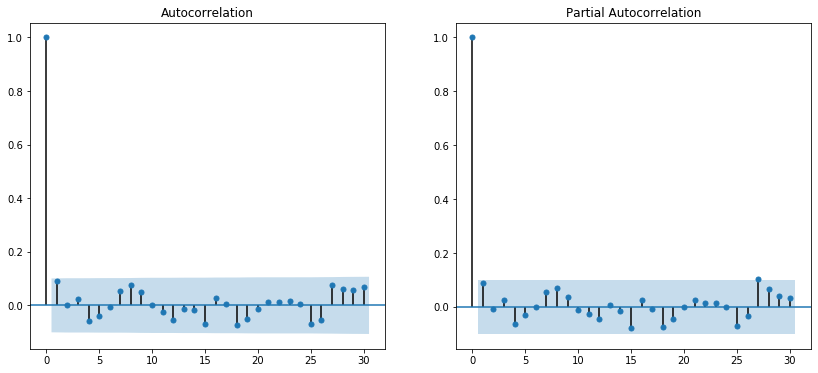

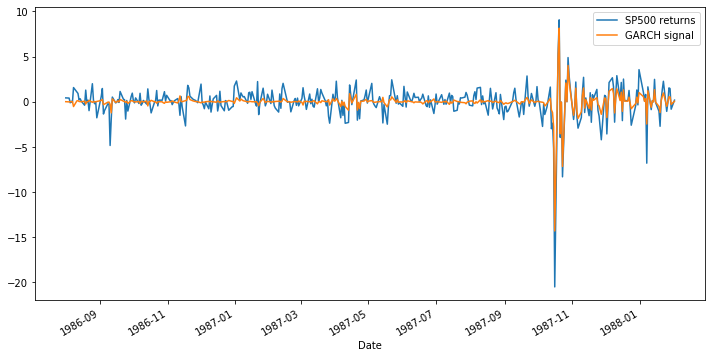

In [79]:
#
# Capture Heteroskedasticy by means of a GARCH model. Heteroskedasticy should be visible!
# We can use GARCH() model alone without ARIMA component as the return series appears 
# to be already stationary (apart from variance).
#
# For simplicity we focus on a shorter time period, around October 1987 to inspect if GARCH
# model can detect the tremendous volatility spike around the "Black Monday" crisis 

# rescaling by 100 is also perform to help convergence of fitting algorithm
sp500_returns_train = sp500_returns['08-01-1986':'02-01-1988'] * 100 

# center around mean
sp500_returns_train = sp500_returns_train - sp500_returns_train.mean()

# display reduced data
plt.figure()
sp500_returns_train.plot(figsize=(12,6), title='SP500 returns around Black Monday')

# 
# Start with a GARCH(1,1) model.
#
garch = arch_model(sp500_returns_train, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(disp='final')# disp final print info on algo convergence
print('\n**************\n')

# print the summary for model fitting (check parameters)
print(fgarch.summary(), end='\n\n***************\n\n')

# print the output of Lagrangian Multiplier test for Heteroskedasticy
print(fgarch.arch_lm_test(), end='\n\n***************\n\n')

# Display conditional variance (which should come from GARCH model) and standard variance (i.e. uncorrelated noise)
fig_varplot = fgarch.plot();
fig_varplot.set_figwidth(12);
fig_varplot.set_figheight(10);

# Just as double check compare the conditional vola plotted with the conditional vola explicitly generated
# from the GARCH formula exploiting the fitted parameters
OMEGA, ALPHA, BETA = fgarch.params

sp500_ret_values = sp500_returns_train.values
estimated_vola = [sp500_ret_values[0]]
for i in range(1, sp500_ret_values.size):
    garch_estimated_vola = np.sqrt(OMEGA + ALPHA * (sp500_ret_values[i-1]**2) + BETA * (estimated_vola[i-1]**2))
    estimated_vola.append(garch_estimated_vola)

plt.figure();
estimated_vola_series = pd.Series(data=estimated_vola, index=sp500_returns_train.index)
estimated_vola_series.plot(title='Conditional vola redrawn from GARCH best-fit params', figsize=(12,5));

# if the conditional volatility from GARCH captures all the vola clusters/spike,
# then the standardized residuals should be pure uncorrelated noise (e.g. gaussian white noise)

# Check visually and through tests if standardized residuals are actually normally distributed
std_resid = fgarch.std_resid
fig_std_resid, ax_std_resid = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# KDE plot
std_resid.plot(ax=ax_std_resid[0], kind='kde', title='Standardized residuals KDE')

# Quantile-Quantile plot
stats.probplot(std_resid, dist='norm', plot=ax_std_resid[1])

_, ax_acf_resid = plt.subplots(nrows=1, ncols=2, figsize=(14,6));
# Display ACF and PACF of residuals: no correlation should be present if GARCH model captured all correlations
plot_acf(std_resid, lags=30, ax=ax_acf_resid[0]);
plot_pacf(std_resid, lags=30, ax=ax_acf_resid[1]);

# It seems that there is no significant autocorrelation among residuals, though it's not so evident.
# From a look at the quantile-quantile plot, we can see that the noise exhibits a fat tail over losses.
# Maybe the simple GARCH model was not able to capture fully the abrupt loss on Black Monday, indeed
# a negative spike is still present in std residuals plot.

# To have an idea of what is the part of the signal which is captured by the GARCH model,
# the original returns are displayed against themselves but with the standardized residuals removed
_, ax_compare = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
sp500_returns_train.plot(label='SP500 returns', ax=ax_compare)
ax_compare.plot(sp500_returns_train - fgarch.std_resid, label='GARCH signal')
ax_compare.legend()

